In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import os
import random
random.seed(1984)

Using TensorFlow backend.


In [2]:
data_dir = "../newspaper-data/"

In [21]:
train_df = pd.read_csv(data_dir+'us_news_train.csv')
test_df = pd.read_csv(data_dir+'us_news_test.csv')
validation_df = pd.read_csv(data_dir+'us_news_validation.csv')

In [4]:
train_df.head()

,outlet,outlet_url,datetime,url_orig,headline,description,author,domain,topic_tags,text,section,news_keywords,subsection,paywall,provider,ideology
0,cnbc,https://www.cnbc.com/,2019-03-15T09:00:46Z,https://www.cnbc.com/2019/03/15/iea-report-ven...,Venezuela's electricity crisis could trigger '...,A nationwide power failure in crisis-stricken ...,Sam Meredith,Oil,"WTI Crude (Apr'19), ICE Brent Crude (May'19), ...",A nationwide power failure in crisis-stricken ...,NaN,"Venezuela, oil, electricity, IEA, report, OPEC...",NaN,NaN,NaN,center
1,cnbc,https://www.cnbc.com/,2018-10-01T10:30:36Z,https://www.cnbc.com/2018/10/01/canadas-husky-...,Canada's Husky Energy offers to buy MEG Energy...,Canadian oil and gas producer Husky Energy sai...,CNBC,Energy,"Oil and Gas, Business, Energy, Canada, US: New...",Canadian oil and gas producer Husky Energy sai...,NaN,"Husky Energy, MEG, mergers and acquisitions, M...",NaN,NaN,NaN,center
2,cnbc,https://www.cnbc.com/,2018-08-16T13:15:32Z,https://www.cnbc.com/2018/08/16/travel-apps-to...,3 innovative new travel apps that save time an...,From the cheapest rideshare to 30 percent off ...,Jimmy Im,Make It - Life,"Tourism, Travel, Career advice, Entrepreneursh...",Millennials are more likely to increase vacati...,NaN,"make it, hoteltonight, daily drop, jetlag, tim...",NaN,NaN,NaN,center
3,thehill,https://www.thehill.com/,2018-05-03T19:09:42Z,http://thehill.com/homenews/administration/386...,EXCLUSIVE: Giuliani calls for Sessions to 'ste...,“I am waiting for the Attorney General to step...,Niall Stanage,Administration,"Russia Investigation, Rudy Giuliani, Michael C...",Rudy Giuliani called for Attorney General Jeff...,Homenews,NaN,NaN,NaN,NaN,center
4,bbcnews,https://www.bbc.co.uk/news,2018-07-16T14:36:28Z,https://www.bbc.co.uk/sport/golf/44850075,The Open 2018: Tiger Woods with late tee time ...,Tiger Woods receives a tee time of 15:21 BST f...,NaN,Golf,NaN,Three-time champion Tiger Woods has a late sta...,Sport,NaN,NaN,NaN,NaN,center


In [22]:
# simple label encoding of "ideology" variable 
train_df["ideology_code"] = train_df["ideology"].astype('category')
train_df.dtypes

outlet             object
outlet_url         object
datetime           object
url_orig           object
headline           object
description        object
author             object
domain             object
topic_tags         object
text               object
section            object
news_keywords      object
subsection         object
paywall            object
provider           object
ideology           object
ideology_code    category
dtype: object

In [23]:
train_df["ideology_code"] = train_df["ideology_code"].cat.codes

center: 0
leanleft: 1
leanright: 2
left: 3
right: 4

In [28]:
sentences = train_df['headline'].values
y = train_df['ideology_code'].values

In [29]:
sentences = sentences.astype('U')

In [30]:
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1984)

In [31]:
vectorizer = CountVectorizer(stop_words="english")
vectorizer.fit(sentences_train)

X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

In [32]:
X_train

<60000x32280 sparse matrix of type '<class 'numpy.int64'>'
	with 465974 stored elements in Compressed Sparse Row format>



`CountVectorizer` performs tokenization which separates the sentences into a set of tokens. It additionally removes punctuation and special characters and can apply other preprocessing to each word. If you want, you can use a custom tokenizer from the NLTK library with the CountVectorizer or use any number of the customizations which you can explore to improve the performance of your model.

The classification model we are going to use is the logistic regression which is a simple yet powerful linear model that is mathematically speaking in fact a form of regression between 0 and 1 based on the input feature vector. By specifying a cutoff value (by default 0.5), the regression model is used for classification.


In [33]:
classifier = LogisticRegression(solver='saga', multi_class='multinomial')
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.4933


---

## Sequential model in keras

In [34]:
input_dim = X_train.shape[1]  # Number of features

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [35]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10)                322810    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 322,821
Trainable params: 322,821
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)

Train on 60000 samples, validate on 20000 samples
Epoch 1/20
60000/60000 [==============================] - 44s 741us/step - loss: -17.3540 - acc: 0.2827 - val_loss: -16.0154 - val_acc: 0.2380
Epoch 2/20
60000/60000 [==============================] - 38s 629us/step - loss: -17.3655 - acc: 0.2836 - val_loss: -15.9559 - val_acc: 0.2379
Epoch 3/20
60000/60000 [==============================] - 37s 617us/step - loss: -17.3720 - acc: 0.2845 - val_loss: -15.9094 - val_acc: 0.2391
Epoch 4/20
60000/60000 [==============================] - 44s 726us/step - loss: -17.3807 - acc: 0.2855 - val_loss: -15.9631 - val_acc: 0.2371
Epoch 5/20
60000/60000 [==============================] - 43s 710us/step - loss: -17.3860 - acc: 0.2863 - val_loss: -15.9006 - val_acc: 0.2379
Epoch 6/20
60000/60000 [==============================] - 37s 609us/step - loss: -17.3882 - acc: 0.2868 - val_loss: -15.9200 - val_acc: 0.2377
Epoch 7/20
60000/60000 [==============================] - 39s 653us/step - loss: -17.3927 - 

In [38]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.2891
Testing Accuracy:  0.2374


In [39]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

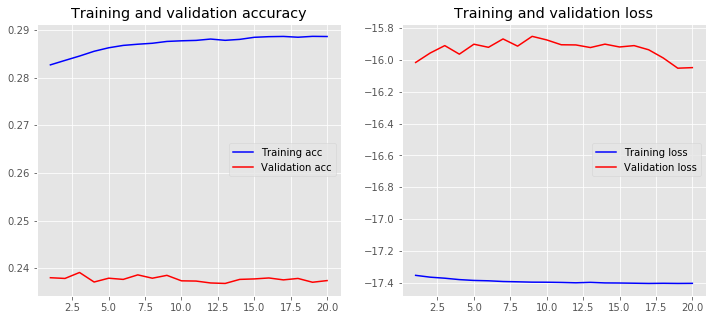

In [40]:
plot_history(history)

## CNNs

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

In [12]:
maxlen = 100
embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          4691100   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 4,756,529
Trainable params: 4,756,529
Non-trainable params: 0
_________________________________________________________________


In [13]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

ValueError: Error when checking input: expected embedding_1_input to have shape (100,) but got array with shape (32280,)

In [35]:
X_train

[[735, 555, 272, 11, 334, 673, 1698, 9, 4437, 3, 85],
 [1638, 436],
 [651, 3208, 2526, 1021, 2, 554, 574, 9, 4279, 4, 4438, 936, 574, 736],
 [75, 287, 899, 10, 126, 13],
 [1227, 1317, 363, 93, 56, 1, 1248, 89, 17],
 [2208, 210, 543, 1150],
 [2, 40, 1228, 1775, 145, 5, 96, 89, 2291, 1572, 145, 3371, 20, 2, 125],
 [3047, 335, 1, 360, 83, 405, 1, 83, 2712],
 [1662, 1, 1022, 906, 1266, 1142, 14],
 [555, 1023, 18, 176, 19, 554, 421],
 [6, 806, 4111, 1639, 666, 1, 2775, 473, 115, 109],
 [1861, 2387, 3969, 4, 138, 416],
 [140, 1718, 764, 306, 80, 1151, 12, 99, 2843, 4280],
 [4597, 1318, 1477, 1, 25, 180, 132, 825, 2983, 31, 8, 2, 807],
 [409, 110, 410, 1478, 1, 4598, 84, 130, 223, 2332],
 [1640, 18, 2, 279, 509, 4, 2, 1249, 621, 1, 62, 94, 406, 49, 43, 636],
 [63, 5, 607, 4, 67, 181, 91, 1143, 439],
 [7, 4439, 1401, 314, 196, 550, 1800, 976, 1, 214, 23, 2, 990],
 [6, 14, 25, 8, 642, 334, 621, 674, 3, 2, 165],
 [2527, 826, 783, 1, 1319, 1380, 858],
 [2, 101, 1088, 65, 288, 345, 827],
 [923, 78